In [ ]:
import tensorflow as tf
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import Model
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [ ]:
num_classes=38

In [ ]:
!git clone https://github.com/spMohanty/PlantVillage-Dataset

Cloning into 'PlantVillage-Dataset'...
remote: Enumerating objects: 163229, done.
remote: Total 163229 (delta 0), reused 0 (delta 0), pack-reused 163229
Receiving objects: 100% (163229/163229), 2.00 GiB | 31.88 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (182401/182401), done.


In [ ]:
train_folder_path = '/content/PlantVillage-Dataset/raw/color'
# Get the list of class (species) folders
train_class_folders = glob(train_folder_path + '/*')

# Initialize lists to store images and labels
images = []
labels = []

# Load images and labels from subfolders
for class_folder in train_class_folders:
    label = (class_folder.split('/')[-1])  # Adjust the index based on your folder structure
    # Get the list of image file paths in the current class folder
    image_files = glob(class_folder + '/*.JPG')
    image_files2 = glob(class_folder + '/*.jpg')  # Update the extension based on your image format
    # Load and resize images
    for image_file in image_files:
        img = cv2.imread(image_file)
        img = cv2.resize(img, (60, 60))  # Adjust the size as needed
        images.append(img)
        labels.append(label)

    for image_file in image_files2:
        img = cv2.imread(image_file)
        img = cv2.resize(img, (60, 60))  # Adjust the size as needed
        images.append(img)
        labels.append(label)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Optionally, normalize pixel values to be in the range [0, 1]
images = images.astype('float32') / 255.0

# Print the shape of the data
print("x_train shape:", images.shape)
print("y_train shape:", labels.shape)


x_train shape: (54303, 60, 60, 3)
y_train shape: (54303,)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Label encoding
label_encoder = LabelEncoder()
labels1 = label_encoder.fit_transform(labels)

# One-hot encoding
labels = to_categorical(labels1,num_classes)

# Display the results
print("Integer Encoded Labels:", labels1)
print("One-Hot Encoded Labels:\n", labels)

Integer Encoded Labels: [23 23 23 ... 36 36 36]
One-Hot Encoded Labels:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
x_val, x_test, y_val, y_test=train_test_split(x_temp, y_temp, test_size=0.5,random_state=0)

In [ ]:
input_shape = images.shape[1:]
print(input_shape)

(64, 64, 3)


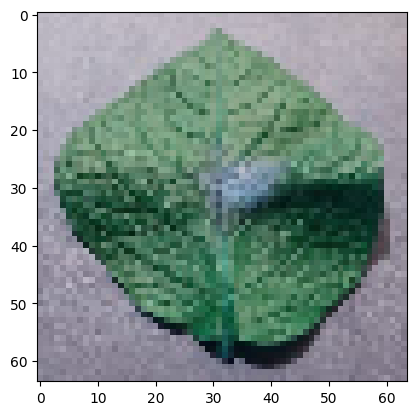

In [ ]:
show_data(images[0])

In [ ]:
# Load the ResNet-50 model
model = keras.applications.ResNet50V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(64, 64, 3), pooling='avg', classes=38,
    classifier_activation="softmax",
)
batch=32
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(learning_rate=0.001),
                 metrics=['accuracy'])



In [ ]:
trained_model1 = model.fit(x_train, y_train,
    epochs=50,
    batch_size=batch,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping])

Epoch 1/50
1188/1188 [==============================] - 110s 62ms/step - loss: 1.0454 - accuracy: 0.6917 - val_loss: 1.0608 - val_accuracy: 0.7002
Epoch 2/50
1188/1188 [==============================] - 70s 59ms/step - loss: 0.4823 - accuracy: 0.8470 - val_loss: 2.9227 - val_accuracy: 0.4478
Epoch 3/50
1188/1188 [==============================] - 67s 57ms/step - loss: 0.3511 - accuracy: 0.8862 - val_loss: 2.3686 - val_accuracy: 0.5569
Epoch 4/50
1188/1188 [==============================] - 68s 57ms/step - loss: 0.2725 - accuracy: 0.9112 - val_loss: 0.7716 - val_accuracy: 0.7737
Epoch 5/50
1188/1188 [==============================] - 69s 58ms/step - loss: 0.2059 - accuracy: 0.9316 - val_loss: 1.0584 - val_accuracy: 0.7352
Epoch 6/50
1188/1188 [==============================] - 67s 56ms/step - loss: 0.1819 - accuracy: 0.9402 - val_loss: 0.5305 - val_accuracy: 0.8483
Epoch 7/50
1188/1188 [==============================] - 67s 57ms/step - loss: 0.1610 - accuracy: 0.9481 - val_loss: 0.4180 

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

255/255 [==============================] - 5s 19ms/step - loss: 0.1436 - accuracy: 0.9624


[0.14364394545555115, 0.9624355435371399]

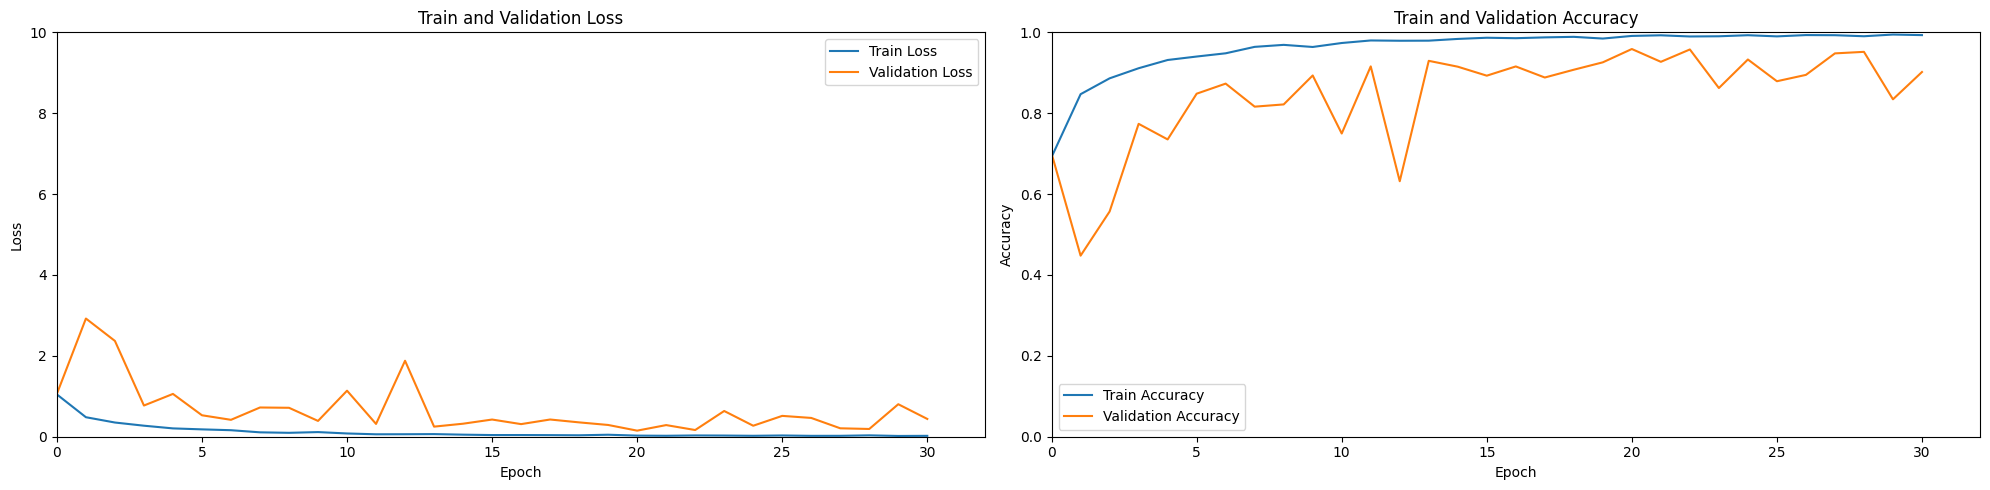

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(trained_model1.history['loss'],label="Train Loss")
plt.plot(trained_model1.history['val_loss'], label="Validation Loss")
plt.xlim(0,32)
plt.ylim(0,10)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(trained_model1.history['accuracy'], label="Train Accuracy")
plt.plot(trained_model1.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0,32)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()

In [ ]:
# Load the ResNet-101 model
model = keras.applications.ResNet101V2(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(60, 60, 3), pooling='avg', classes=38,
    classifier_activation="softmax",
)
batch=32
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Compile the model
model.compile(loss='categorical_crossentropy',
                 optimizer=Adam(learning_rate=0.001),
                 metrics=['accuracy'])



In [ ]:
trained_model2 = model.fit(x_train, y_train,
    epochs=50,
    batch_size=batch,
    verbose=1,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping])

Epoch 1/50
1188/1188 [==============================] - 184s 104ms/step - loss: 1.1651 - accuracy: 0.6598 - val_loss: 1.9225 - val_accuracy: 0.5476
Epoch 2/50
1188/1188 [==============================] - 122s 102ms/step - loss: 0.5435 - accuracy: 0.8288 - val_loss: 3.2997 - val_accuracy: 0.4000
Epoch 3/50
1188/1188 [==============================] - 122s 103ms/step - loss: 0.3886 - accuracy: 0.8731 - val_loss: 1.4044 - val_accuracy: 0.6258
Epoch 4/50
1188/1188 [==============================] - 118s 99ms/step - loss: 0.2963 - accuracy: 0.9033 - val_loss: 3.7757 - val_accuracy: 0.3449
Epoch 5/50
1188/1188 [==============================] - 123s 103ms/step - loss: 0.2447 - accuracy: 0.9209 - val_loss: 1.0957 - val_accuracy: 0.7084
Epoch 6/50
1188/1188 [==============================] - 118s 100ms/step - loss: 0.1994 - accuracy: 0.9348 - val_loss: 1.3395 - val_accuracy: 0.6913
Epoch 7/50
1188/1188 [==============================] - 119s 100ms/step - loss: 0.1593 - accuracy: 0.9466 - val_l

In [ ]:
model.evaluate(x_test,y_test,verbose=1)

255/255 [==============================] - 7s 29ms/step - loss: 0.2269 - accuracy: 0.9365


[0.22694270312786102, 0.9365332722663879]

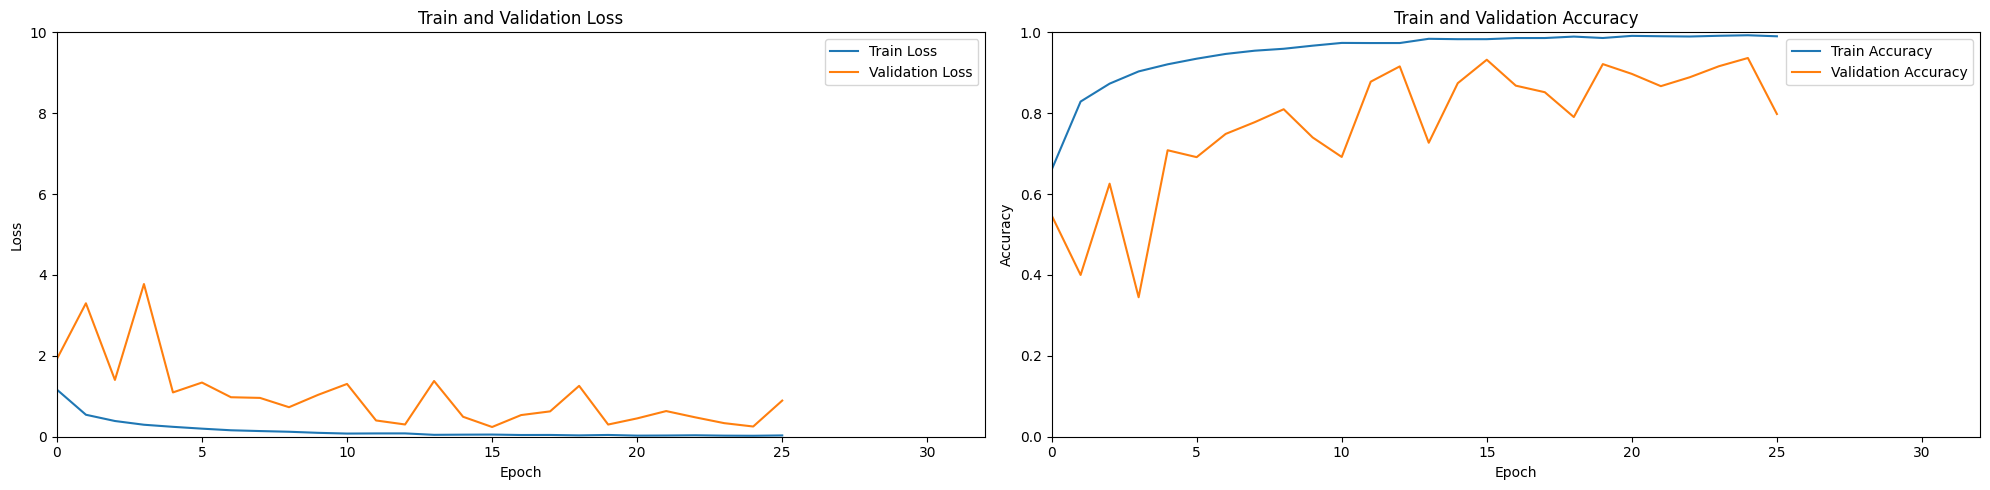

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(1,2,1)
plt.title("Train and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(trained_model2.history['loss'],label="Train Loss")
plt.plot(trained_model2.history['val_loss'], label="Validation Loss")
plt.xlim(0,32)
plt.ylim(0,10)
plt.legend()

plt.subplot(1,2,2)
plt.title("Train and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.plot(trained_model2.history['accuracy'], label="Train Accuracy")
plt.plot(trained_model2.history['val_accuracy'], label="Validation Accuracy")
plt.xlim(0,32)
plt.ylim(0,1)
plt.legend()
plt.tight_layout()